In [1]:
import torch
from torch import nn, optim
from torchsummary import summary
import torchvision
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils import tensorboard
from torchvision.models import resnet18
import zipfile
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [3]:
print(torch.cuda.device_count())

1


In [4]:
augs = T.Compose([
    T.RandomRotation(degrees = 20),
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_augs=  T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [5]:
img_files = os.listdir('data/train/train')

def train_path(p):
    return f"data/train/train/{p}"

img_files = list(map(train_path, img_files))
random.shuffle(img_files)

train = img_files[:20000]
val = img_files[20000:]

for i in range(100):
    print(train[i])

class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

data/train/train/dog.6720.jpg
data/train/train/dog.2651.jpg
data/train/train/cat.6968.jpg
data/train/train/dog.2163.jpg
data/train/train/dog.11751.jpg
data/train/train/dog.7983.jpg
data/train/train/cat.9090.jpg
data/train/train/dog.6489.jpg
data/train/train/cat.2685.jpg
data/train/train/dog.12147.jpg
data/train/train/dog.1193.jpg
data/train/train/cat.11372.jpg
data/train/train/cat.8835.jpg
data/train/train/dog.10145.jpg
data/train/train/dog.11793.jpg
data/train/train/cat.11907.jpg
data/train/train/cat.1069.jpg
data/train/train/dog.12144.jpg
data/train/train/dog.6514.jpg
data/train/train/dog.1472.jpg
data/train/train/cat.5102.jpg
data/train/train/cat.8406.jpg
data/train/train/cat.6386.jpg
data/train/train/cat.7975.jpg
data/train/train/dog.9924.jpg
data/train/train/dog.8668.jpg
data/train/train/cat.196.jpg
data/train/train/cat.12161.jpg
data/train/train/dog.9315.jpg
data/train/train/dog.11505.jpg
data/train/train/dog.1691.jpg
data/train/train/dog.6245.jpg
data/train/train/dog.5763.jpg
da

In [6]:
train_data = CatDogDataset(train, augs)
val_data = CatDogDataset(val, test_augs)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


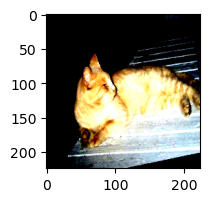

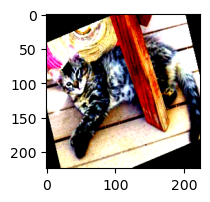

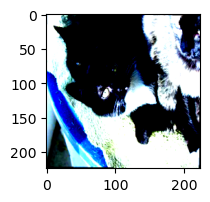

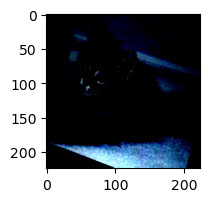

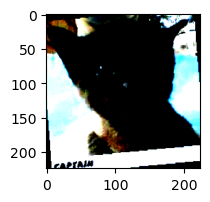

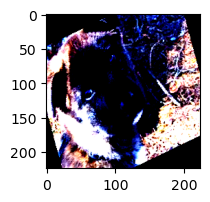

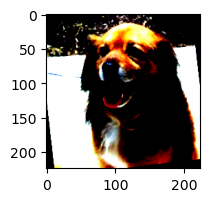

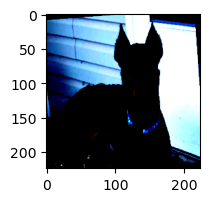

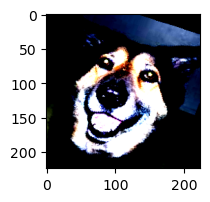

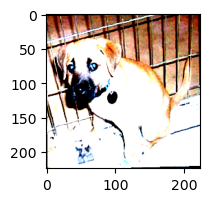

In [7]:
def imshow(img):
    plt.figure(figsize=(2,2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(10):
    print(labels[i])
    imshow(torchvision.utils.make_grid(images[i]))

In [8]:
def ResNet18(num_classes =2):
    model = resnet18(weights = 'IMAGENET1K_V1')
    # freezing the learner
    for params in model.parameters():
        params.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features,512, bias = True),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,num_classes),
        nn.Softmax(-1)
    )
    return model

model = ResNet18()
model.to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4,verbose = True, min_lr = 0.00001)
num_epochs = 20

In [10]:
train_acc_list = []
val_acc_list = []

train_loss_list = []
val_loss_list = []

es_count = 0 # Patience for LR scheduler
curr_epoch = 0
curr_loss = 0
best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    curr_epoch = epoch
    if es_count == 10:
        print("Stop training")
        break
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
        train_acc += accuracy.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()

    val_acc = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
            val_acc += accuracy.item()

        val_acc /= len(val_loader)
        val_loss /= len(val_loader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        if val_acc > best_val_acc:
            best_epoch = epoch
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    scheduler.step(val_loss)

    if abs(val_loss - curr_loss) < 0.005 or val_loss > curr_loss:
        es_count += 1
        curr_loss = val_loss
    else:
        es_count = 0
        curr_loss = val_loss

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Acc: {train_acc:.4f} - Validation Acc: {val_acc:.4f}")

Epoch 1/20 - Training Acc: 0.9408 - Validation Acc: 0.9713
Epoch 2/20 - Training Acc: 0.9607 - Validation Acc: 0.9672
Epoch 3/20 - Training Acc: 0.9636 - Validation Acc: 0.9767
Epoch 4/20 - Training Acc: 0.9667 - Validation Acc: 0.9757
Epoch 5/20 - Training Acc: 0.9668 - Validation Acc: 0.9693
Epoch 6/20 - Training Acc: 0.9692 - Validation Acc: 0.9782
Epoch 7/20 - Training Acc: 0.9683 - Validation Acc: 0.9782
Epoch 8/20 - Training Acc: 0.9691 - Validation Acc: 0.9767
Epoch 9/20 - Training Acc: 0.9689 - Validation Acc: 0.9763
Epoch 10/20 - Training Acc: 0.9689 - Validation Acc: 0.9759
Epoch 11/20 - Training Acc: 0.9702 - Validation Acc: 0.9786
Epoch 12/20 - Training Acc: 0.9703 - Validation Acc: 0.9773
Epoch 13/20 - Training Acc: 0.9716 - Validation Acc: 0.9771
Epoch 14/20 - Training Acc: 0.9715 - Validation Acc: 0.9727
Epoch 15/20 - Training Acc: 0.9728 - Validation Acc: 0.9784
Epoch 16/20 - Training Acc: 0.9726 - Validation Acc: 0.9788
Epoch 17/20 - Training Acc: 0.9702 - Validation A

In [11]:
train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)
train_acc_list = np.array(train_acc_list)
val_acc_list = np.array(val_acc_list)

writer = SummaryWriter()

writer.flush()
for i in range(curr_epoch):
    writer.add_scalars('Loss', {'Train': train_loss_list[i], 'Test': val_loss_list[i]}, i)
    writer.add_scalars('Accuracy', {'Train': train_acc_list[i], 'Test': val_acc_list[i]}, i)

writer.close()


In [12]:
for params in model.parameters():
    params.requires_grad = True
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
optimizer2 = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01, weight_decay=1e-5)
loss_func2 = nn.CrossEntropyLoss(reduction = 'mean')
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, patience = 4,verbose = True, min_lr = 0.00001)
num_epochs = 20

In [14]:
train_acc_list = []
val_acc_list = []

train_loss_list = []
val_loss_list = []

es_count = 0
curr_epoch = 0
curr_loss = 0
best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    curr_epoch = epoch
    if es_count == 10:
        print("Stop training")
        break
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer2.zero_grad()
        outputs = model(inputs)
        loss = loss_func2(outputs, labels)
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
        accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
        train_acc += accuracy.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()

    val_acc = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_func2(outputs, labels)
            val_loss += loss.item()
            accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
            val_acc += accuracy.item()

        val_acc /= len(val_loader)
        val_loss /= len(val_loader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        if val_acc > best_val_acc:
            best_epoch = epoch
            best_val_acc = val_acc
            torch.save(model.state_dict(), "finetune_model.pth")

    scheduler2.step(val_loss)

    if abs(val_loss - curr_loss) < 0.005 or val_loss > curr_loss:
        es_count += 1
        curr_loss = val_loss
    else:
        es_count = 0
        curr_loss = val_loss

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Acc: {train_acc:.4f} - Validation Acc: {val_acc:.4f}")

Epoch 1/20 - Training Acc: 0.9691 - Validation Acc: 0.9778
Epoch 2/20 - Training Acc: 0.9775 - Validation Acc: 0.9775
Epoch 3/20 - Training Acc: 0.9778 - Validation Acc: 0.9812
Epoch 4/20 - Training Acc: 0.9822 - Validation Acc: 0.9846
Epoch 5/20 - Training Acc: 0.9870 - Validation Acc: 0.9842
Epoch 6/20 - Training Acc: 0.9881 - Validation Acc: 0.9852
Epoch 7/20 - Training Acc: 0.9896 - Validation Acc: 0.9800
Epoch 8/20 - Training Acc: 0.9893 - Validation Acc: 0.9828
Epoch 9/20 - Training Acc: 0.9908 - Validation Acc: 0.9848
Epoch 10/20 - Training Acc: 0.9918 - Validation Acc: 0.9877
Stop training
